In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ageSuperflexPy.lumped_model import LumpedModel

from ageSuperflexPy.pegasus import PegasusPython
from ageSuperflexPy.numerical_ODE_solvers import ImplicitEulerPython
from ageSuperflexPy.reservoirs import PowerReservoirHBV, PowerReservoirNorm
from ageSuperflexPy.structure_elements import Transparent, Junction, Splitter

In [2]:
# Import data
df_data = pd.read_csv('data/data.csv')

# Define numpy arrays of data
J = df_data['J [mm/h]'].to_numpy()
Q = df_data['Q [mm/h]'].to_numpy()
ET = df_data['ET [mm/h]'].to_numpy()
Cin = df_data['Cin [-]'].to_numpy()

In [3]:
# Functional two bucket model

# Define model parameters
S_u_ref = float(100)
S_l_ref = float(2000)
b_u = float(10)
b_l = float(20)
nu = 0.5
P_bar = np.mean(J)

# Initialize hydrological components
orig_data_len = len(J)

S_u = np.zeros(orig_data_len + 1)
S_l = np.zeros_like(S_u)

L = np.zeros(orig_data_len)
Q_l = np.zeros_like(L)
Q_s = np.zeros_like(L)

S_u[0] = S_u_ref
S_l[0] = S_l_ref

In [4]:
# Initialize numerical routines
root_finder = PegasusPython()
numeric_approximator = ImplicitEulerPython(root_finder=root_finder)

# Initialize the elements
upper_storage = PowerReservoirHBV(
    parameters={'k': P_bar / S_u_ref**b_u, 'alpha': b_u},
    states={'S0': S_u_ref},
    approximation=numeric_approximator,
    id='Su'
)

lower_storage = PowerReservoirHBV(
    parameters={'k': (1-nu)*P_bar / S_l_ref**b_l, 'alpha': b_l},
    states={'S0': S_l_ref},
    approximation=numeric_approximator,
    id='Sl'
)

splitter = Splitter(direction=[[0], [0]], weight=[[nu], [nu]], id='splitter')
transparent = Transparent(id='transparent')
junction = Junction(direction=[[0,0]], id='junction')

# Initialize the Unit
model = LumpedModel(
    layers=[[upper_storage], [splitter], [lower_storage, transparent], [junction]]
)

In [5]:
# Run SuperflexPy model
model.set_input([J])
model.set_timestep(1.0)
Q_s_SP = model.get_output()

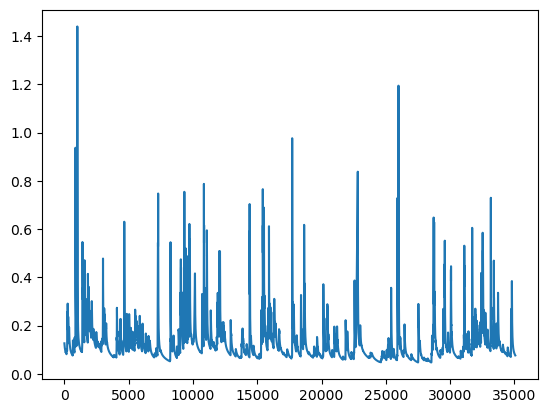

In [6]:
plt.plot(Q_s_SP[0])

In [7]:
# Get internal fluxes and storages of the model
L_SP = np.array(model.call_internal(id='Su', method='get_output', solve=False)).ravel()
Ql_SP = np.array(model.call_internal(id='Sl', method='get_output', solve=False)).ravel()

Su_SP = model.get_internal(id='Su', attribute='state_array').ravel()
Sl_SP = model.get_internal(id='Sl', attribute='state_array').ravel()